# 16-820: Advanced Computer Vision - HW6 - 2023

## Introduction

In this homework we will work with the state-of-the-art foundation model for segmentation, [SAM](http://segment-anything.com/)  - [Paper](http://ai.meta.com/research/publications/segment-anything/). Foundation models are large deep learning neural networks that are trained on massive datasets. SAM and other segmentation models use input prompts such as a box around an object to generate a mask of just the object. We will learn how to run off-the-shelf deep learning models and use them in your work. We will use 2D segmentation masks, combined with camera geometry and depth, to arrive at dense 3D point clouds from 2D segmentations.  The steps you will implement are:
* Run SAM on a single image from the dataset.
* Project the mask to 3D points in world coordinates.
* For all the unseen views, do: 
    1. Project all points in world coordinates to the image frame. 
    2. Automatically generate a new input to SAM and run SAM
    3. Project new mask to world coordinates and append to existing coordinates.
* Filter the point cloud using an off-the-shelf filtering approach.

Homework introduction video [here](https://youtu.be/rUQeJzlkfoU?si=udOHm5W5nRyy0WG8).
To submit this homework to gradescope, please submit <strong>your code and the output of your code</strong>. E.g., for Q4 show the function you implemented and the visualizations created in the for loop. For Q1.1, give the K matrix you computed.

Instructor: David Held \
OUT: November 27th, 2023 \
DUE: December 6th, 2023 \
TA's: Bardienus Duisterhof, Dishani Lahiri, Vineet Tambe, Ronit Hire


### Definitions

A couple definitions that will hopefully avoid confusion:

These are the existing `frames`:
* Camera frame/OpenCV Camera Frame: This is the reference frame for 3D points with respect to the camera. This is the camera frame discussed in class.
* Blender Camera Frame: This is the camera frame for 3D points used in Blender, the `y` and `z` axes point in opposite direction w.r.t. the OpenCV camera frame.
* World Frame: This is the frame for 3D points with respect to the world origin. This frame differs by a rigid body transformation from any camera frame.
* Image Frame: The <strong> 2D points </strong> in the image, e.g., `u`, `v` in range [0,H] and [0,W]. 

If we refer to a `prompt` we mean the box around an object that is to be segmented, which is the input to SAM. 


### How to run this homework

We will use deep neural networks which require a cuda-enabled graphics card with at least 12GB of VRAM. The easiest way to get access to this is Google Colab, press the button below to open this homework in Google Colab. You'll find a pretty useful tutorial on how to use Google Colab [here](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj#scrollTo=cLkX9vxT2VBR).

<a target="_blank" href="https://colab.research.google.com/github/16820AdvancedCV/hw6/blob/main/HW6.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Environment Set-up with Google Colab

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
# using_colab = True

In [2]:
# if using_colab:
#     # install everything
#     import torch
#     import torchvision
#     print("PyTorch version:", torch.__version__)
#     print("Torchvision version:", torchvision.__version__)
#     print("CUDA is available:", torch.cuda.is_available())
#     import sys
#     !{sys.executable} -m pip install opencv-python matplotlib os
#     ! pip install open3d
#     !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#     !mkdir ckpts
#     !wget -P ckpts https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#     ! pip install gdown
#     ! gdown 1K375xNjWAwZ7kmhjTuJccC3y6Ik5tN4q #download dataset from gdrive
#     ! unzip images.zip

In [3]:
# from IPython.display import Image
# img_size = 400
# Image(filename="images/data_demo.gif", width=img_size, height=img_size)

## Environment Set-up without Google Colab



If you're not running on Google Colab, use the [prep_no_colab.sh](prep_no_colab.sh) script to install the right libraries, pull the model checkpoint and download the data. This script was tested on Ubuntu Linux only. After running the script your folder should look something like this:
```
├── images
│   ├── dataset
│   │   ├── train
|   |   ├── test
|   |   ├── val
│   │   ├── transforms_train.json
│   │   ├── transforms_test.json
│   │   ├── transforms_val.json
├── ckpts
│   ├── sam_vit_h_4b8939.pth
```

Our recommended method for loading iPython notebooks on your local computer is to use a Visual Studio Code plugin, [here](https://code.visualstudio.com/docs/datascience/jupyter-notebooks) is a short tutorial on how to do that. Are you having issues setting up your system? Problems with Cuda versions? Use Colab instead, or ask a TA if you really want to use your own compute.

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os


In [5]:
def show_mask(mask, ax, random_color=False):
    # This function is used to visualize the mask on the image in a matplotlib axis.
    # bool mask: (H, W). True for each pixel that belongs to the object.
    # ax: matplotlib axis
    # random_color: if True, use a random color for the mask. Otherwise, use blue. 

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    # This function is used to visualize the bounding box on the image in a matplotlib axis.
    # box: (4,) array. [x0, y0, x1, y1]
    # (x0, y0): top-left corner
    # (x1, y1): bottom-right corner
    # ax: matplotlib axis
    
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Q1: Loading and Understanding the Dataset [2 pts]

The dataset you'll be working with is a synthetic dataset generated specifically for this homework. We used the free and open-source 3D graphics software tool [Blender](https://www.blender.org/) to render images from 100 different poses. You will have access to the following data:
* The intrinsics parameters, constant for all images. The dataset was rendered using a pinhole camera model without distortion. Therefore, the intrinsics can be captured using camera matrix K.
* The extrinsics, as a [100 x 4 x 4] array. Each [4 x 4] matrix gives the cam2world transformation.
* File path to the 100 images, each of shape [800 x 800 x 3].
* 100 depth images, each of shape [800 x 800 x 3]. Each channel has the depth in meters, so 2 channels are redundant.

We will now load and visualize the dataset.


#### Q1.1 Compute the camera matrix K [2 pts]


In [6]:
import json

# dataset class provided to load extrinsics, intrinsics and image paths.
class Dataset:
    def __init__(self, json):
        self.json = json # the json file containing the extrinsics, intrinsics and image paths.
        self.load_extrinsics()
        self.load_intrinsics()
        self.compute_intrinsics()

    def load_extrinsics(self):
        # This function loads the extrinsics parameters from the json file.

        with open(self.json) as f:
            self.data = json.load(f)
        self.frames = self.data['frames'] # 'frames' in the json contains the extrinsics and image path for each image.
        self.transforms = np.array([frame['transform_matrix'] for frame in self.frames]) # extrinsic matrix for each image, shape (N, 4, 4)
        self.file_paths = np.array([frame['file_path'] for frame in self.frames]) # path to each image, shape (N,)

    def load_intrinsics(self):
        # This function loads the intrinsics parameters from the json file.
        self.f_x = self.data['fl_x'] # focal length in x
        self.f_y = self.data['fl_y'] # focal length in y
        self.w = self.data['w'] # image width
        self.h = self.data['h'] # image height
        self.cx = self.data['cx'] # principal point in x
        self.cy = self.data['cy'] # principal point in y

    def compute_intrinsics(self):
        self.K = None # K: the intrinsic matrix, shape (3, 3)
        # compute the K matrix form the intrinsic parameters computed in load_intrinsics() : [2 pts]
        # TODO: YOUR CODE HERE
        self.K = np.array([[self.f_x, 0, self.cx],
                            [0, self.f_y, self.cy],
                            [0, 0, 1]])


dataset = Dataset('images/dataset/transforms_train.json') # load the dataset
np.set_printoptions(precision=3, suppress=True) # do NOT remove this line when you print matrices for grading

print('Shape of extrinsic matrices: {}'.format(dataset.transforms.shape)) # all extrinsic matrices, shape (N, 4, 4)
#TODO: print the intrinsic matrix and add to your gradescope submission.
print('K matrix {}'.format(dataset.K)) # The intrinsic matrix K you computed.

Shape of extrinsic matrices: (100, 4, 4)
K matrix [[1111.111    0.     400.   ]
 [   0.    1111.111  400.   ]
 [   0.       0.       1.   ]]


#### Visualize the dataset [0 pts]

Here we show the RGB and depth data that are part of the dataset. Reasoning about algorithm design is often easier when you understand the data.

In [7]:
image = cv2.imread(os.path.join('images/dataset',dataset.file_paths[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

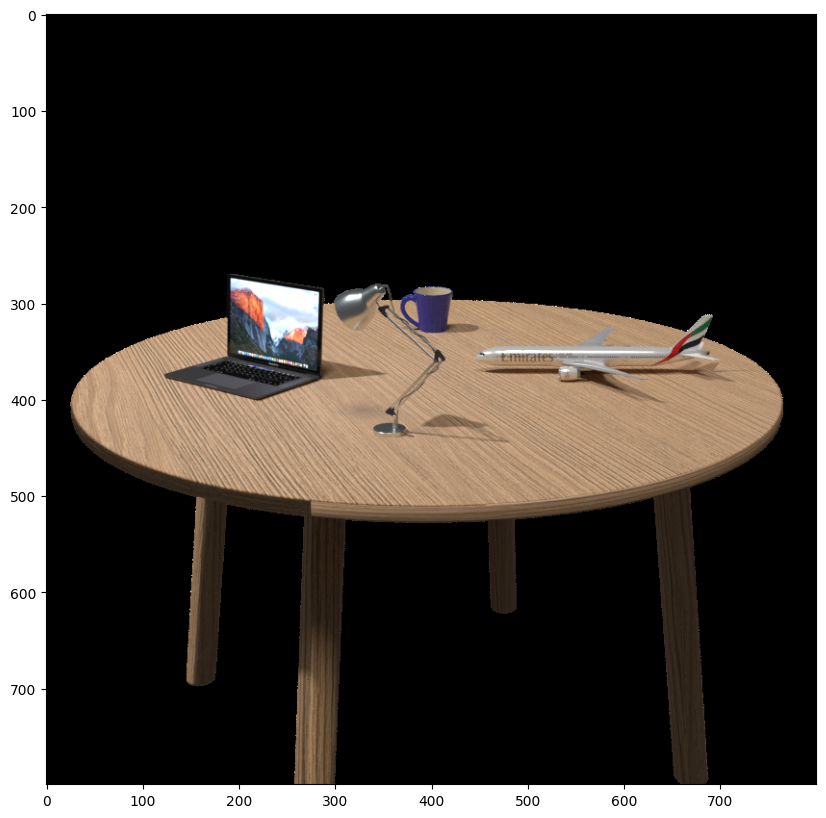

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()


In [9]:

def depthmap_viz(depth,min_d=0.0,max_d=3.5):
    # depth: (H,W,3) - depth map, every channel contains the same depth values for that pixel. 2 channels are redundant.
    
    # min_d: minimum depth value to visualize
    # max_d: maximum depth value to visualize

    depth = np.clip(depth,min_d,max_d)
    
    depth = (depth-min_d)/(max_d - min_d)

    image = depth

    plt.clf()
    plt.imshow(depth,cmap='magma', vmin=min_d,vmax=max_d)

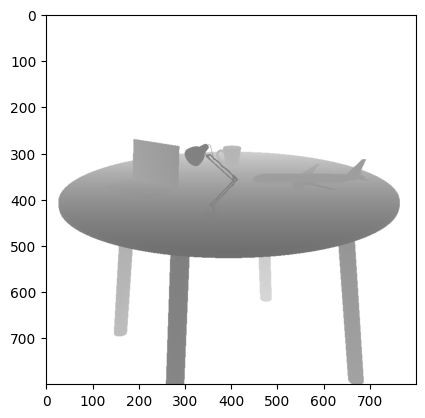

In [10]:
depth_location = 'images/dataset/train/depth.npy' # location of ground truth depth maps.
depths = np.load(depth_location) # load the depth maps

depthmap_viz(depths[0]) # visualize the first depth map
plt.show() # show the plot

#### Loading SAM [0 pts]

The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

Here we load the SAM model and predictor. Running on CUDA and using the default model are recommended for best results. Do not change any settings, as it will complicate our grading, you may not receive full credit if you alter the SAM settings.

In [11]:
import sys
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "ckpts/sam_vit_h_4b8939.pth" # the checkpoint loaded in the setup section.
model_type = "vit_h" 

device = "cuda" # loading to GPU.

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## Q2: Designing our prompt [2 point]

SAM and other segmentation models use input prompts such as a box around an object to generate a mask of the object. From now on if we refer to a `prompt` we mean the box around an object that is to be segmented, which is the input to SAM.

In this homework we will start by acquiring a single user-generated `prompt` in one image: a box around the coffee mug. We will then use depth and camera geometry to propogate the mask to other frames. It is therefore important for the one user-specified prompt to be high-quality. Set the `input_box` parameter such that we can get a high-quality segmentation.

Now we load in the first example image into the model.

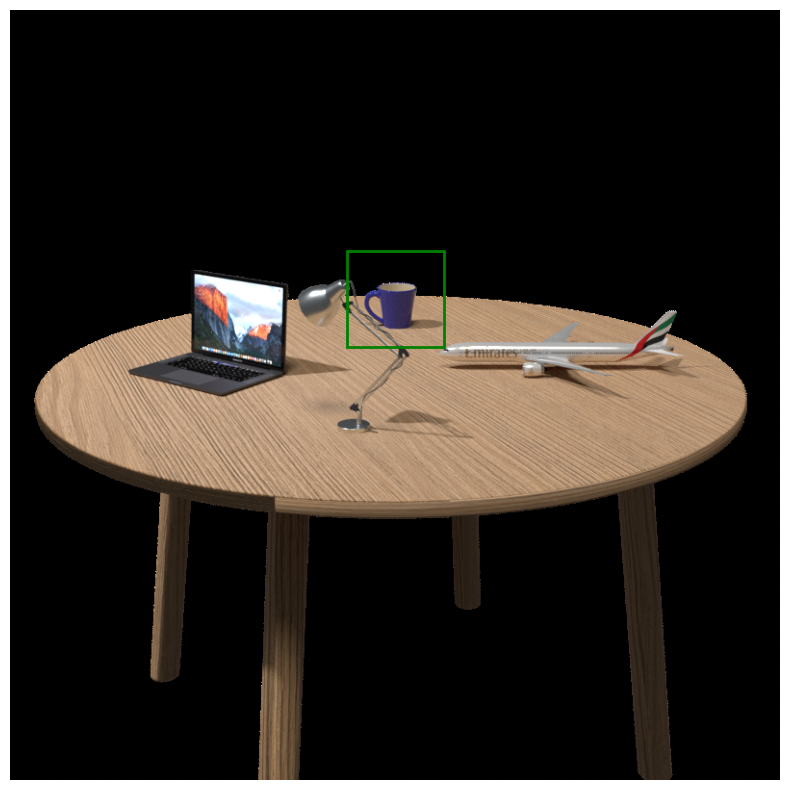

In [12]:
#TODO: YOUR CODE HERE
# add this plot to gradescope submission.
input_box = np.array([350, 250, 450, 350]) # choose correct bounding box [2 pts]

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [13]:
# Here we're running SAM on the image with the bounding box.
predictor.set_image(image) # loading the image to the predictor.
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
) 
# Calling the predictor with the bounding box. 
# You will not need to change any of the other arguments in this homework.


#### Visualizing the mask.

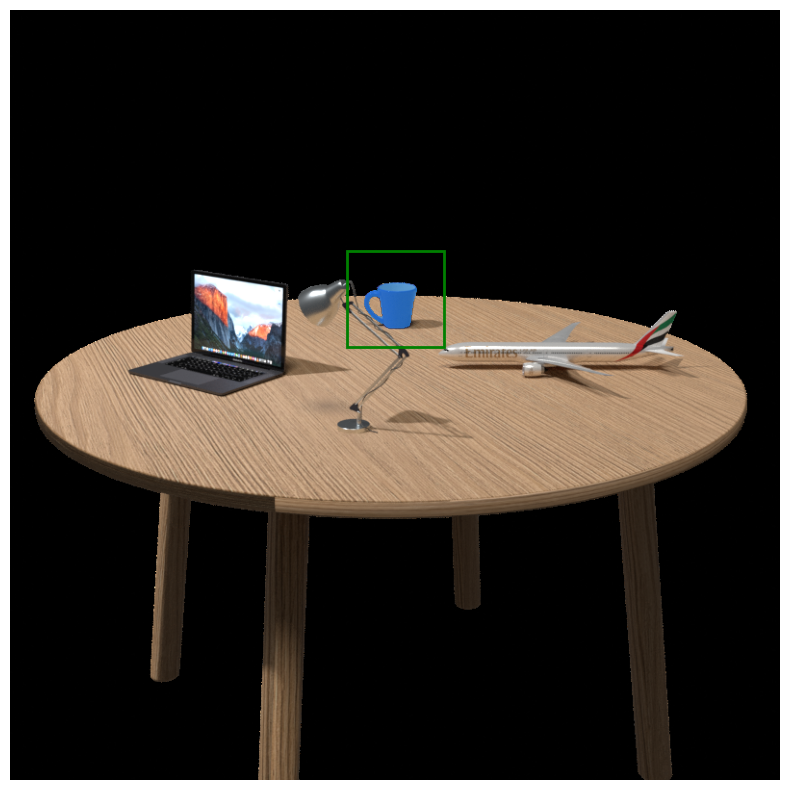

In [14]:
mask = masks[0]
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Q3: Project to 3D  [20 points]

As discussed before, the aim of this homework is to use the image mask in one image and propagate it to novel views. In this section we will use the mask generated in the previous question, and project the pixels in the mask to 3D coordinates using depth and camera geometry. Remember we can project points in image coordinates to 3D points by using the P matrix, with P = K[R|t].

## Q3.1: Image frame to camera frame [10 pts]

In this part of the question you will be asked to project the points from image frame, so pixel coordinates, to a point cloud in the camera frame. For this you will only need the intrinsic matrix K and the depth. You will not need dataset.transforms in Q2.1.

In [15]:
def img2cam(points, K, depths=None):
    # project the points from image coordinates to camera coordinates [5 pts]
    cam_3d = None 
    
    # TODO: YOUR CODE HERE
    # (1) Use the intrinsic matrix K to convert the points from image coordinates to a point cloud in the camera frame.
    # (2) Normalize the points to a plane with z=1.
    # (3) Use depths to scale the points to be at the correct distance from the camera.
    points[:, [1, 0]] = points[:, [0, 1]] # matrix coordinates xy = image coordinates yx
    pointsT = np.vstack((points.T, np.ones(len(points))))
    points3dT = np.matmul(np.linalg.inv(K), pointsT)
    points3dT[-1, :] = depths.T
    points3dT[:2, :] = points3dT[:2, :]*points3dT[-1, :]
    cam_3d = points3dT
    
    return cam_3d

def filter_points(coords,depths,thresh=2.55):
    # filter out points that are too far away in the first mask, this first mask will be very important! [2 pts] 
    # return filtered coords and depths
    # don't make it too complicated, this should be a one-liner.
    # TODO: YOUR CODE HERE
    
    in_coords, _ = np.where(depths<=thresh)
    coords_f = coords[in_coords]
    depths_f = depths[in_coords]

    return coords_f, depths_f

def mask2cam(mask, K, depths,thresh=None):
    # project mask points to camera frame [3 pts]
    # steps todo:
    # (1) get all coordinates where the mask is True, this should be N x 2
    # (2) get the depth values for these coordinates, Nx1
    # (3) call filter_points to filter out points that are too far away, with depth above the treshold. 
    # Here far away means the depth is above a certain threshold. 
    # (4) call img2cam to convert the points to camera frame using intrinsics and depth.
    # TODO: YOUR CODE HERE
    Xs, Ys, _ = np.where(mask == True)
    coords = np.hstack((Xs.reshape(-1, 1), Ys.reshape(-1, 1)))
    
    l = len(coords)
    Ds = np.zeros((l, 1))
    for i in range(l):
        Ds[i] = depths[coords[i][0], coords[i][1]][0]

    coords_f, Ds_f = filter_points(coords,Ds,thresh)
    points3d = img2cam(coords_f, K, Ds_f)

    return points3d

In [16]:
cam_pnts_3d = mask2cam(mask_image,dataset.K,depths[0],thresh=2.55)
print(cam_pnts_3d)

[[-0.025 -0.023  0.03  ...  0.016  0.018  0.02 ]
 [-0.264 -0.264 -0.264 ... -0.159 -0.159 -0.159]
 [ 2.547  2.549  2.549 ...  2.516  2.518  2.519]]


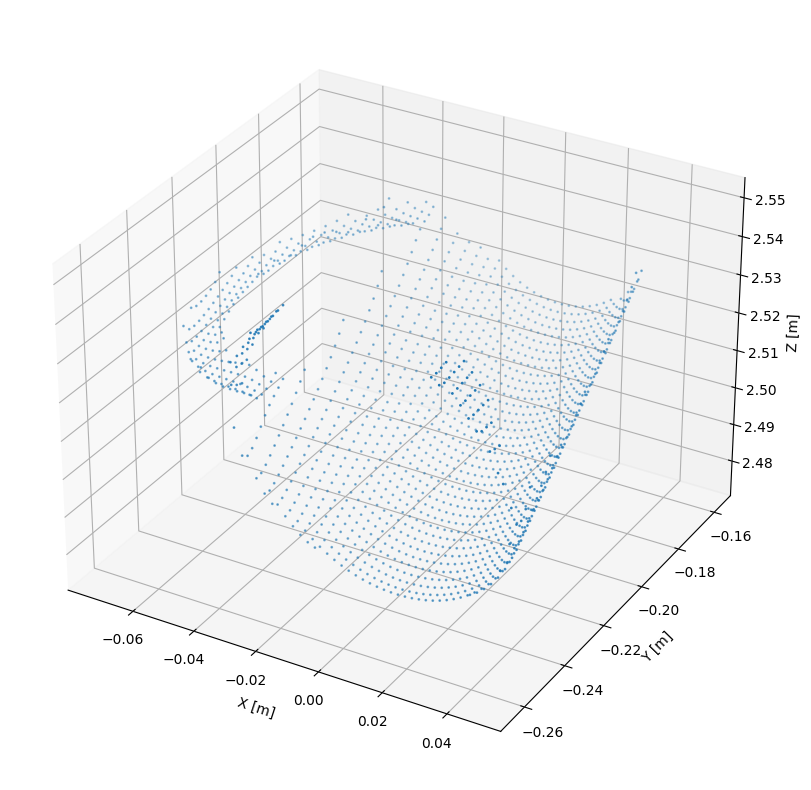

In [17]:
def viz_pts_3d(pts,xrange=None,yrange=None,zrange=None,title=None):
    # viz the 3D points
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[0,:],pts[1,:],pts[2,:],s=1)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')

    if xrange is not None:
        ax.set_xlim(xrange)
    if yrange is not None:
        ax.set_ylim(yrange)
    if zrange is not None:
        ax.set_zlim(zrange)

    if title is not None:
        ax.set_title(title)
    plt.show()

np.save('cam_pnts_3d.npy',cam_pnts_3d)

#TODO: add this plot to gradescope submission
viz_pts_3d(cam_pnts_3d)


## Q3.2: Camera frame to world frame [10 points]

We now project the points in the camera frame to the world frame, keep in mind that the transforms provided are between the world frame and the Blender camera frame (pictured below). You will need to take this difference into account when using the equations of projective geometry. For example, the intrinsics matrix `K` will expect 3D points in the OpenCV camera frame. Summarizing, these are the existing `frames`:
* Camera frame/OpenCV Camera Frame: This is the reference frame for 3D points with respect to the camera, as seen in the class up to now.
* Blender Camera Frame: This is the camera frame for 3D points used in Blender, the `y` and `z` axes are pointing in opposite directions w.r.t. OpenCV frame.
* World Frame: This is the frame for 3D points with respect to the world origin.
* Image Frame: The <strong> 2D points </strong> in the image, e.g., `u`, `v` in range [0,H] and [0,W]. 

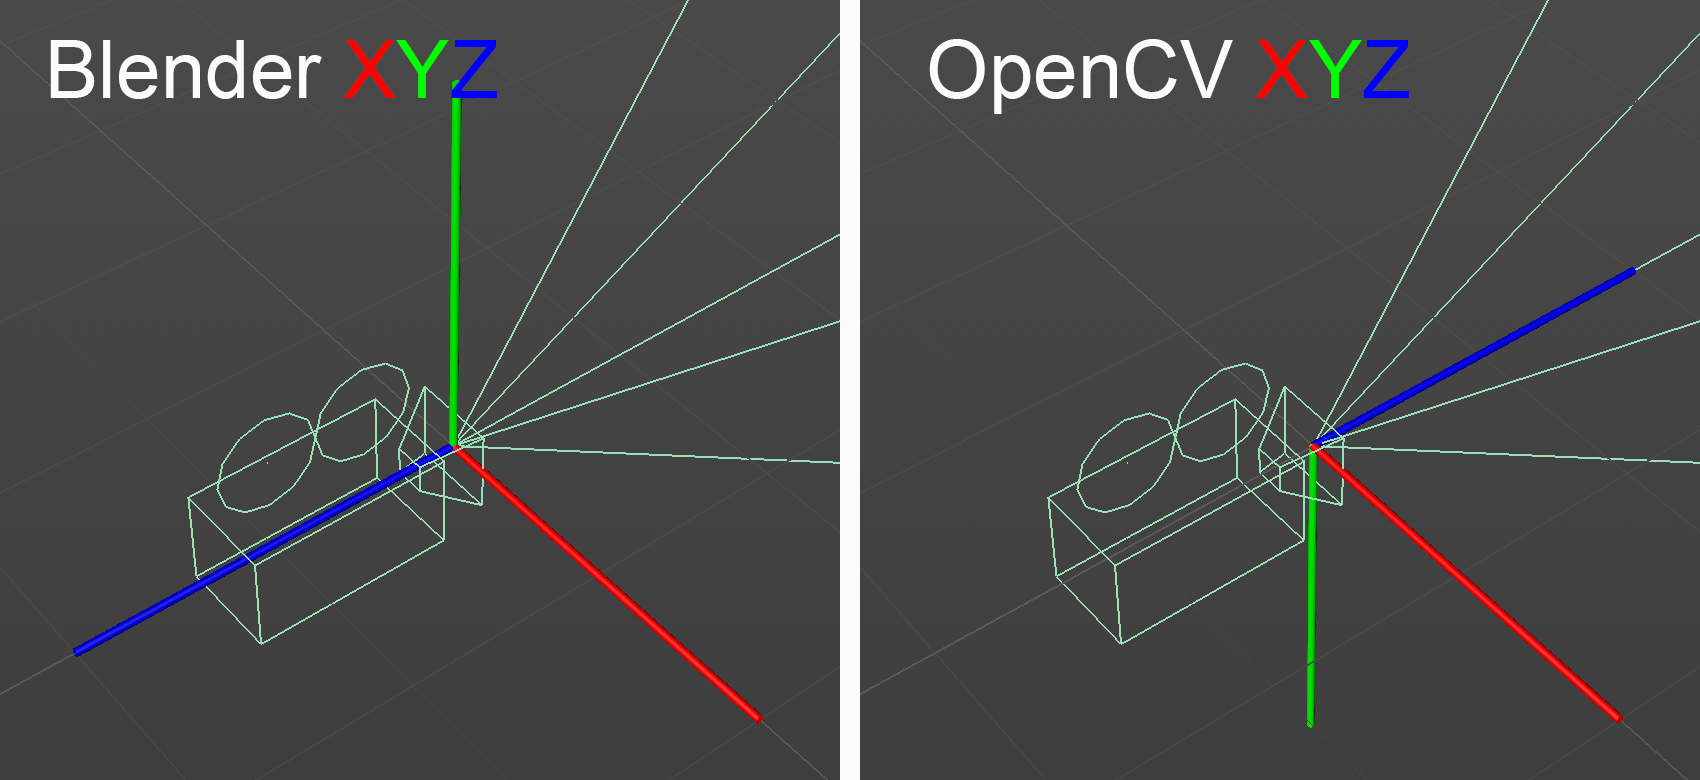

In [18]:
from IPython.display import Image
img_size = 800
Image(filename="images/cam_frames.png", width=img_size)


In [19]:
def cam2world(points,transform):
    # project camera coordinates to world coordinates [5 pts]
    # NOTE: transform is the transformation from the blender camera frame to the world frame.
    # TODO: YOUR CODE HERE
    # -- cv to blender
    points[1, :] = -points[1, :]
    points[2, :] = -points[2, :]
    # -- then to world
    points = np.vstack((points, np.ones(points.shape[1])))
    res = np.matmul(transform, points) 
    res = res[:3, :]
    
    return res

def world2cam(points,transform):
    # project world coordinates to camera coordinates [5 pts]
    # NOTE: do not use np.linalg.inv to compute the inverse of transform, we will award only partial credit.
    # There is an intuitive and elegent way to compute the inverse of transform.
    # NOTE: do not forget about blender coordinates!

    # TODO: YOUR CODE HERE
    points = np.vstack((points, np.ones(points.shape[1])))
    pseudoInv = np.matmul(np.linalg.inv(np.matmul(transform.T, transform)), transform.T)
    res = np.matmul(pseudoInv, points)[:3, :]
    # -- blender to cv
    res[1, :] = -res[1, :]
    res[2, :] = -res[2, :]
    
    return res

In [20]:
def show_mask(mask, ax, random_color=False):
    # This function is used to visualize the mask on the image in a matplotlib axis.
    # bool mask: (H, W). True for each pixel that belongs to the object.
    # ax: matplotlib axis
    # random_color: if True, use a random color for the mask. Otherwise, use blue. 

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    # This function is used to visualize the bounding box on the image in a matplotlib axis.
    # box: (4,) array. [x0, y0, x1, y1]
    # ax: matplotlib axis
    
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


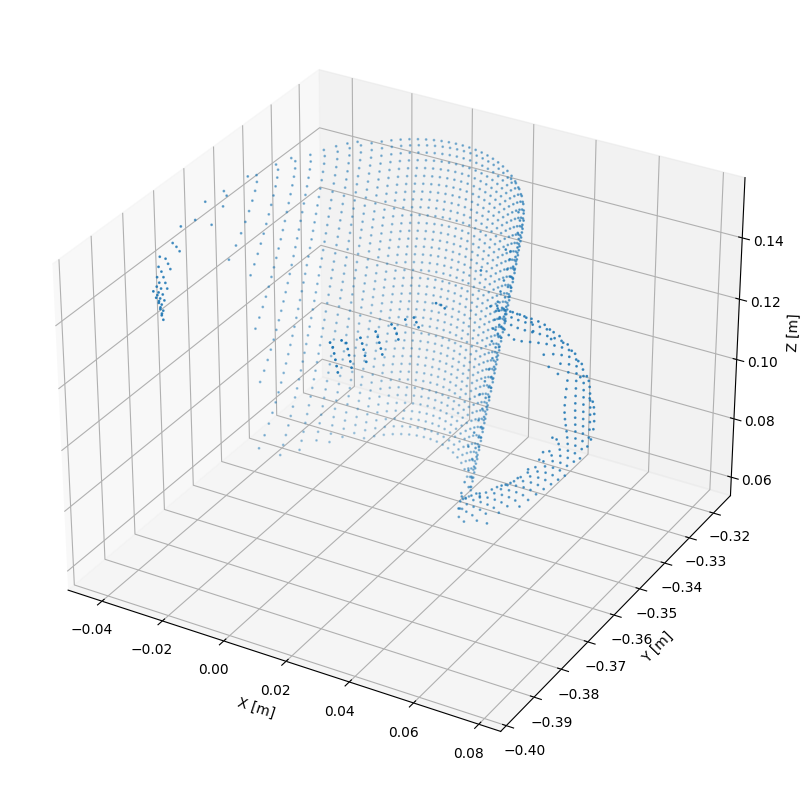

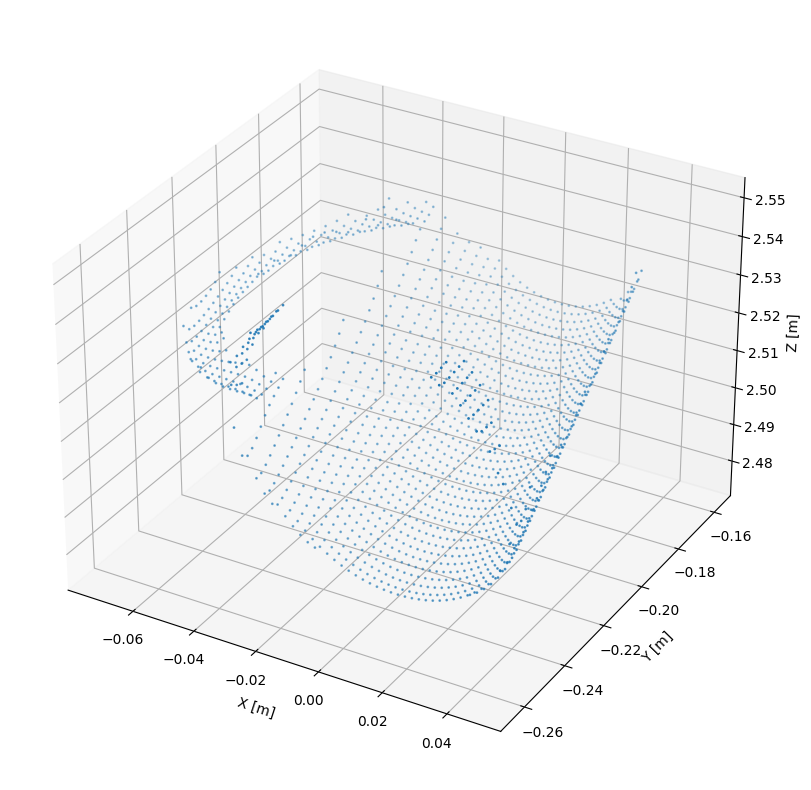

In [21]:
transform_0 = dataset.transforms[0]

world_pts = cam2world(cam_pnts_3d,transform_0)


np.save('world_pts.npy',world_pts)
#TODO: add this plot to gradescope submission
viz_pts_3d(world_pts)

cam_pts_test = world2cam(world_pts, transform_0)
viz_pts_3d(cam_pts_test)

## Q4: Casting masks to new frames [10 pts]

Now we will look at new viewpoints and extract their point clouds. To do this we will loop through new viewpoints one by one, to run SAM on each new image. Each iteration of the loop we add the new 3D points to the previous 3D points, which are then used in the next iteration to create a new mask using projective geometry and depth. 

A simple approach might be to deploy the projective geometry we have developed, and find the bounding box at each iteration based on the coordinate range of the projected point cloud. That is, we project all 3D points to the novel view, an array of [N,2] with each row an x and y coordinate in the image frame. The bounding box could be simply [min_x,min_y,max_x,max_y]. What would be the problem with an approach like this?

Occlussions and noise! Noise can be from some pixels that weren't segmented correctly, occlussions can cause entirely errorneous masks. You will be implementing several functions to improve the results: \
(1) Filter out masks that have a confidence that's too low \
(2) Filter out points that are too far away from anything else we've seen so far. \
(3) Carefully choose the bounding box dimensions to avoid noise to have a big effect on the result.

In [22]:
def cam2img(points, K):
    # project camera coordinates to image coordinates [3 pts]
    # output should be pixel coordinates in the correct range with shape (2, N)
    # TODO: YOUR CODE HERE
    res = np.matmul(K, points)
    res = res/res[-1, :]
    res = res[:2, :]

    return res

In [23]:
# (1) Filter out masks that have a confidence that's too low. [0 pts]

score_thresh = 0.85
def keep_score(score):
    return score > score_thresh

In [24]:
# (2) Filter out points that are too far away from anything else we've seen so far.

dist_thresh = 0.0005 # -- decide on a good distance threshold [2 pts]

def keep_dist(new_pts,existing_pts):
    # TODO: YOUR CODE HERE
    maxx, maxy, maxz = np.max(existing_pts[0, :]), np.max(existing_pts[1, :]), np.max(existing_pts[2, :])
    minx, miny, minz = np.min(existing_pts[0, :]), np.min(existing_pts[1, :]), np.min(existing_pts[2, :])
    condition1 = np.logical_and(new_pts[0, :] <= maxx + dist_thresh, new_pts[0, :] >= minx - dist_thresh)
    condition2 = np.logical_and(new_pts[1, :] <= maxy + dist_thresh, new_pts[1, :] >= miny - dist_thresh)
    condition3 = np.logical_and(new_pts[2, :] <= maxz + dist_thresh, new_pts[2, :] >= minz - dist_thresh)
    condition = np.logical_and(np.logical_and(condition1, condition2), condition3)
    new_pts = new_pts[:, condition]

    return new_pts

In [25]:
# (3) Carefully choose the bounding box dimensions to avoid noise to have a big effect on the result.

# filter out points n_std away from mean of all points [3 pts]
def filter_for_box(world_points,transform, n_std=2):
    # TODO: YOUR CODE HERE
    mean_pt = np.mean(world_points, axis=1)
    std_pt = np.std(world_points, axis = 1)
    condition1 = (np.abs(world_points[0, :] - mean_pt[0]) < n_std*std_pt[0])
    condition2 = (np.abs(world_points[1, :] - mean_pt[1]) < n_std*std_pt[1])
    condition3 = (np.abs(world_points[2, :] - mean_pt[2]) < n_std*std_pt[2])
    condition = np.logical_and(np.logical_and(condition1, condition2), condition3)
    world_points_f = world_points[:, condition]
    cam = world2cam(world_points_f, transform)
    res = cam2img(cam, dataset.K)
    return res

# based on the filtered points, compute the bounding box [2 pts]
def prompt_points_to_box(prompt):
    # TODO: YOUR CODE HERE
    # output: np.array([x0, y0, x1, y1]])
    # (x0, y0): top-left corner
    # (x1, y1): bottom-right corner
    # prompt[:2, :] = prompt[:2, :] / prompt[-1, :]
    min_pt = np.min(prompt, axis = 1)
    max_pt = np.max(prompt, axis = 1)
    res = np.array([min_pt[0], min_pt[1], max_pt[0], max_pt[1]])
    return res


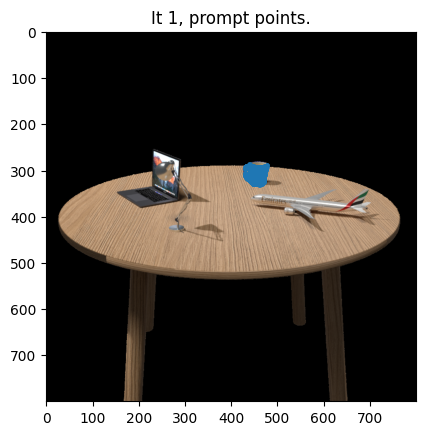

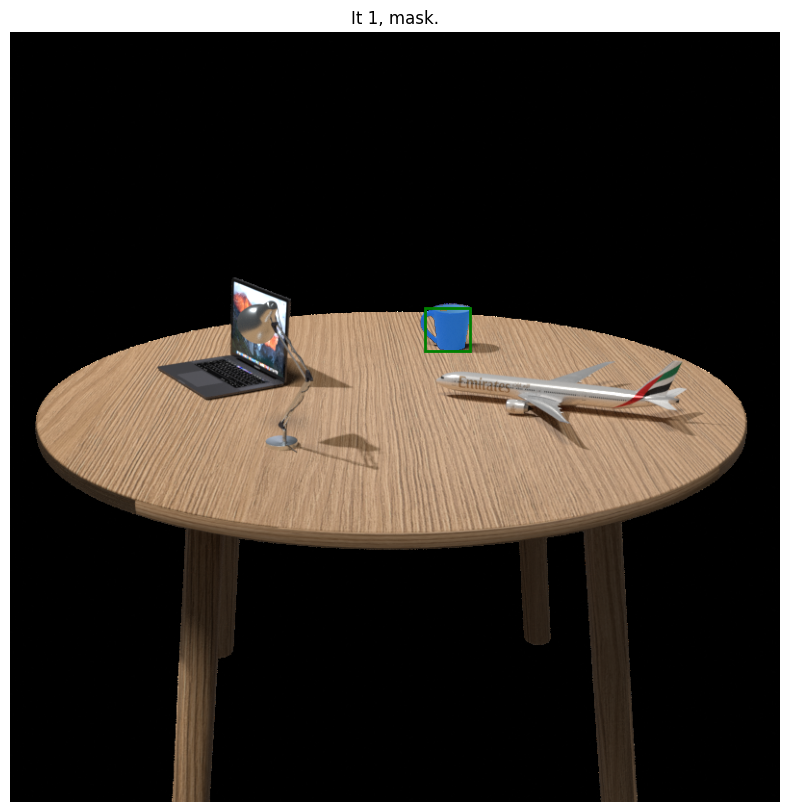

cam_pts_3d [[ 0.13   0.132  0.104 ...  0.143  0.146  0.148]
 [-0.266 -0.266 -0.263 ... -0.157 -0.157 -0.157]
 [ 2.529  2.529  2.519 ...  2.489  2.49   2.492]]
tmp_world_pts [[ 0.019  0.017  0.039 ... -0.021 -0.022 -0.024]
 [-0.402 -0.403 -0.383 ... -0.339 -0.341 -0.343]
 [ 0.153  0.153  0.153 ...  0.062  0.061  0.061]]
new_pts [[ 0.039  0.037  0.035 ... -0.021 -0.022 -0.024]
 [-0.383 -0.385 -0.387 ... -0.339 -0.341 -0.343]
 [ 0.153  0.152  0.152 ...  0.062  0.061  0.061]]
[[ 0.039  0.037  0.035 ... -0.021 -0.022 -0.024]
 [-0.383 -0.385 -0.387 ... -0.339 -0.341 -0.343]
 [ 0.153  0.152  0.152 ...  0.062  0.061  0.061]]


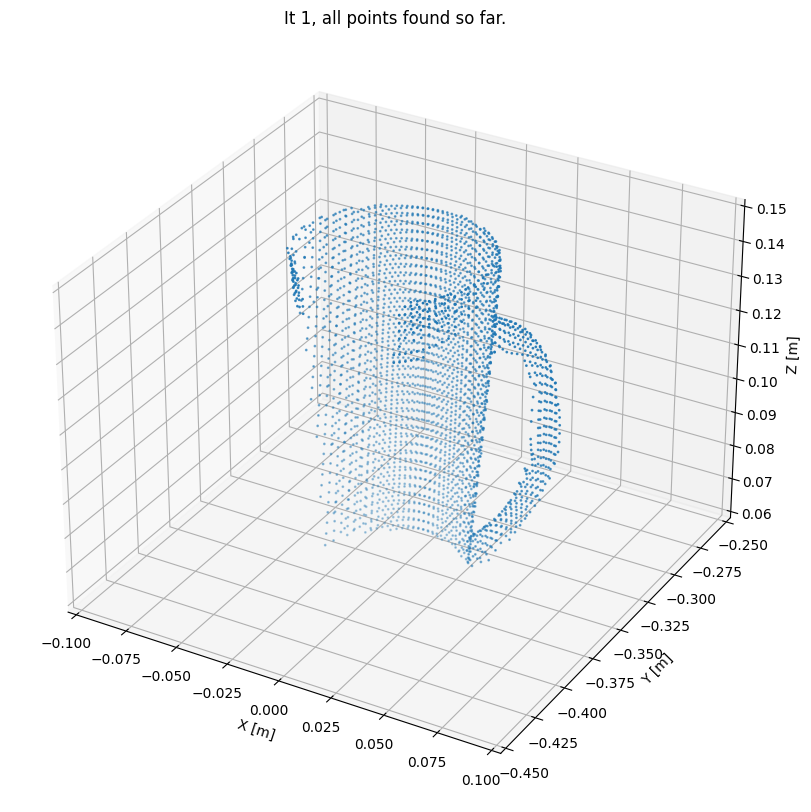

cam_pts_3d [[ 0.312  0.314  0.316 ...  0.323  0.325  0.327]
 [-0.1   -0.1   -0.1   ...  0.011  0.011  0.011]
 [ 2.052  2.052  2.052 ...  2.016  2.016  2.016]]
tmp_world_pts [[ 0.03   0.032  0.033 ... -0.029 -0.028 -0.027]
 [-0.333 -0.335 -0.336 ... -0.375 -0.376 -0.378]
 [ 0.151  0.151  0.151 ...  0.06   0.06   0.06 ]]
new_pts [[ 0.03   0.032  0.033 ... -0.029 -0.028 -0.027]
 [-0.333 -0.335 -0.336 ... -0.375 -0.376 -0.378]
 [ 0.151  0.151  0.151 ...  0.06   0.06   0.06 ]]
[[ 0.03   0.032  0.033 ... -0.029 -0.028 -0.027]
 [-0.333 -0.335 -0.336 ... -0.375 -0.376 -0.378]
 [ 0.151  0.151  0.151 ...  0.06   0.06   0.06 ]]
cam_pts_3d [[0.215 0.217 0.219 ... 0.22  0.221 0.223]
 [0.132 0.132 0.132 ... 0.243 0.243 0.243]
 [1.962 1.962 1.962 ... 2.    2.    2.001]]
tmp_world_pts [[ 0.024  0.025  0.026 ... -0.019 -0.018 -0.016]
 [-0.325 -0.326 -0.327 ... -0.388 -0.389 -0.389]
 [ 0.152  0.152  0.152 ...  0.063  0.063  0.062]]
new_pts [[ 0.024  0.025  0.026 ... -0.019 -0.018 -0.016]
 [-0.325 -0.326

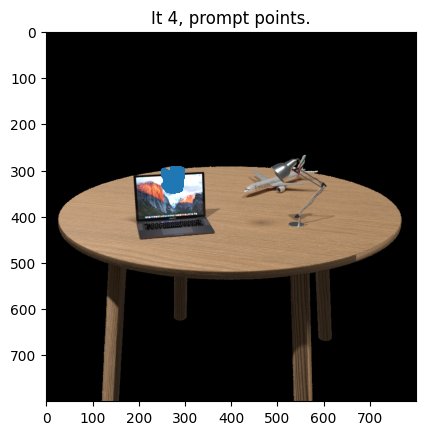

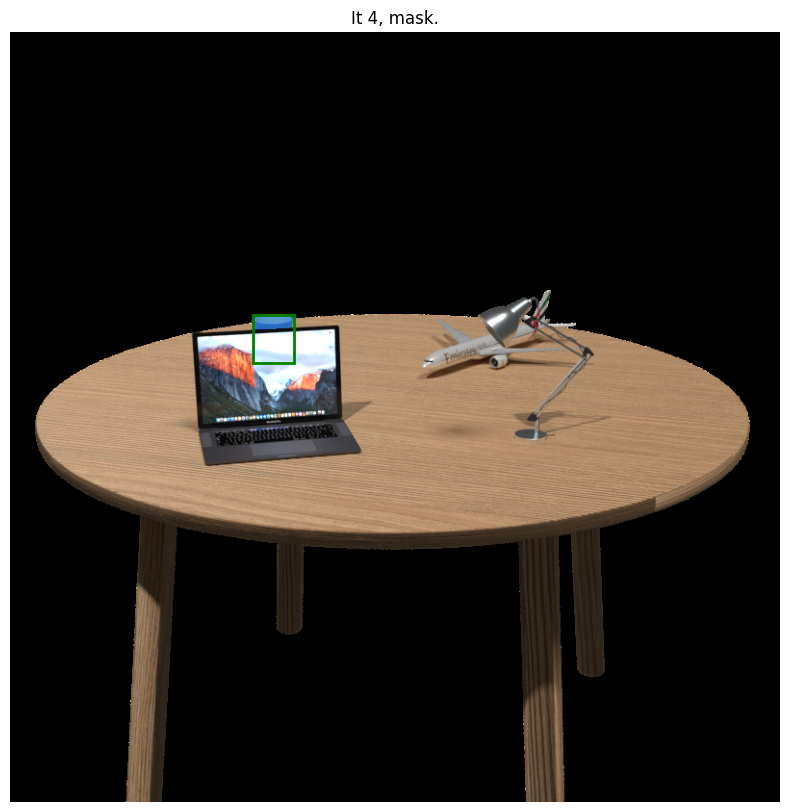

cam_pts_3d [[-0.291 -0.289 -0.287 ... -0.219 -0.217 -0.216]
 [-0.232 -0.232 -0.232 ... -0.16  -0.16  -0.16 ]
 [ 2.433  2.434  2.434 ...  1.932  1.932  1.933]]
tmp_world_pts [[-0.018 -0.02  -0.022 ...  0.31   0.309  0.307]
 [-0.402 -0.401 -0.4   ... -0.02  -0.019 -0.018]
 [ 0.153  0.152  0.152 ...  0.241  0.241  0.241]]
new_pts [[-0.024 -0.025 -0.027 ...  0.041  0.04   0.039]
 [-0.398 -0.397 -0.395 ... -0.348 -0.345 -0.343]
 [ 0.152  0.152  0.152 ...  0.141  0.141  0.141]]
[[-0.024 -0.025 -0.027 ...  0.041  0.04   0.039]
 [-0.398 -0.397 -0.395 ... -0.348 -0.345 -0.343]
 [ 0.152  0.152  0.152 ...  0.141  0.141  0.141]]


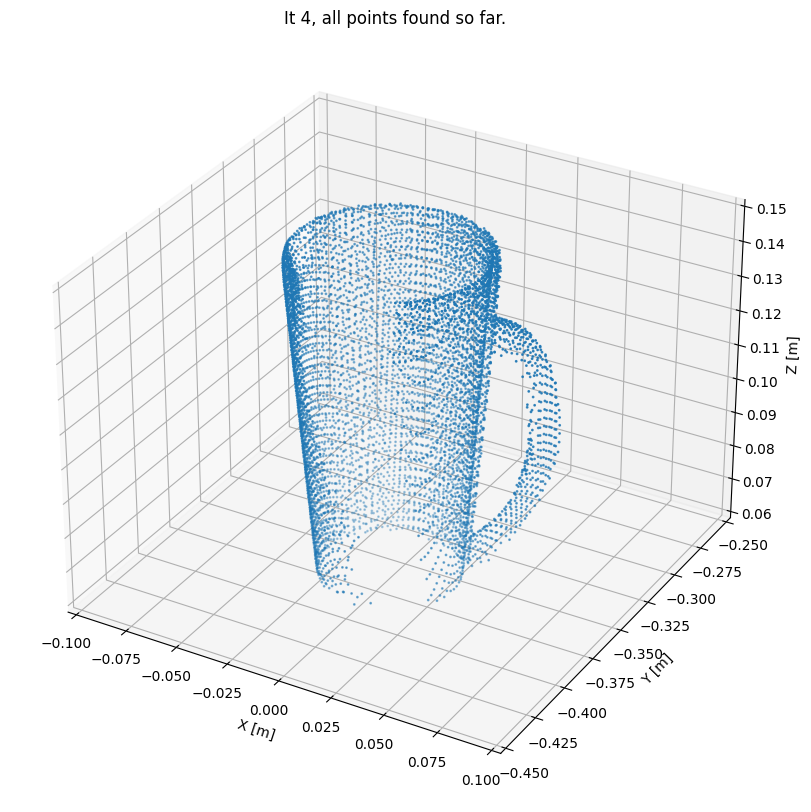

cam_pts_3d [[ 0.346  0.348  0.349 ...  0.362  0.364  0.366]
 [-0.172 -0.172 -0.172 ... -0.053 -0.053 -0.053]
 [ 2.198  2.194  2.193 ...  2.184  2.185  2.185]]
tmp_world_pts [[ 0.062  0.059  0.058 ... -0.031 -0.031 -0.031]
 [-0.356 -0.357 -0.359 ... -0.361 -0.363 -0.365]
 [ 0.138  0.14   0.141 ...  0.061  0.061  0.06 ]]
new_pts [[ 0.062  0.059  0.058 ... -0.031 -0.031 -0.031]
 [-0.356 -0.357 -0.359 ... -0.361 -0.363 -0.365]
 [ 0.138  0.14   0.141 ...  0.061  0.061  0.06 ]]
[[ 0.062  0.059  0.058 ... -0.031 -0.031 -0.031]
 [-0.356 -0.357 -0.359 ... -0.361 -0.363 -0.365]
 [ 0.138  0.14   0.141 ...  0.061  0.061  0.06 ]]
cam_pts_3d [[-0.285 -0.284 -0.282 ... -0.265 -0.264 -0.262]
 [ 0.021  0.021  0.021 ...  0.137  0.137  0.137]
 [ 1.97   1.97   1.97  ...  1.978  1.979  1.98 ]]
tmp_world_pts [[-0.04  -0.039 -0.037 ...  0.028  0.029  0.029]
 [-0.344 -0.343 -0.341 ... -0.376 -0.375 -0.373]
 [ 0.152  0.152  0.152 ...  0.061  0.06   0.06 ]]
new_pts [[-0.04  -0.039 -0.037 ...  0.028  0.029  0.02

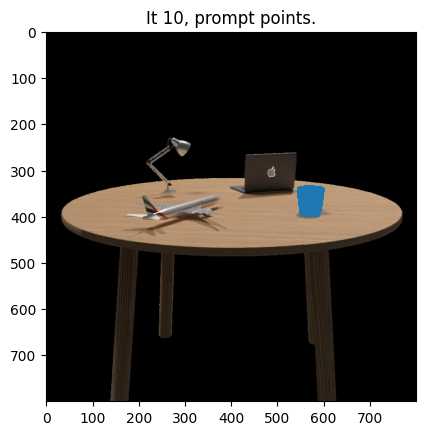

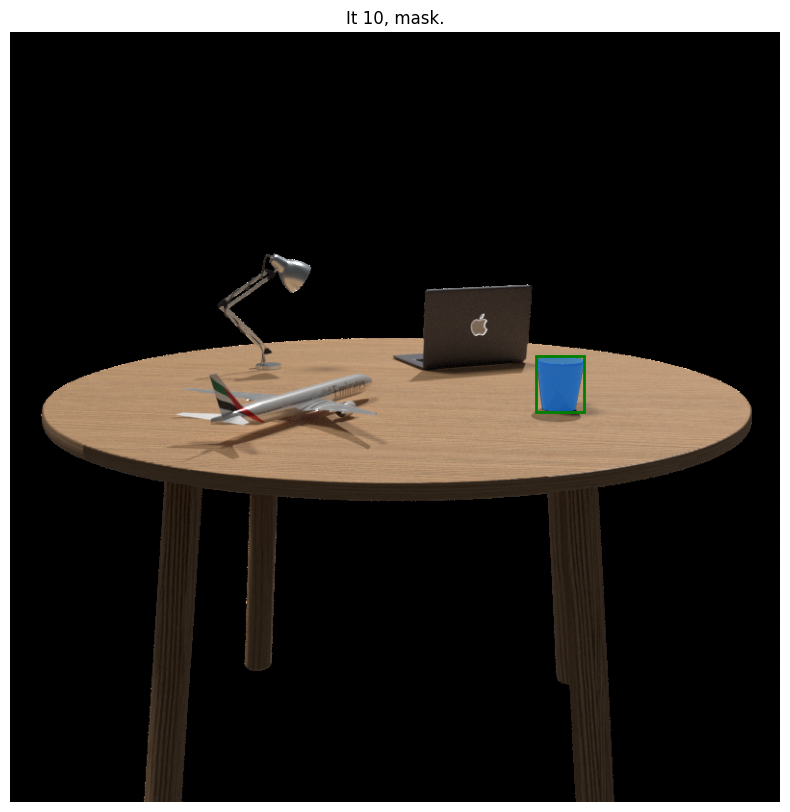

cam_pts_3d [[ 0.288  0.29   0.292 ...  0.317  0.319  0.321]
 [-0.115 -0.115 -0.116 ... -0.011 -0.011 -0.011]
 [ 2.036  2.036  2.037 ...  1.99   1.99   1.991]]
tmp_world_pts [[ 0.021  0.022  0.024 ... -0.022 -0.02  -0.019]
 [-0.325 -0.326 -0.327 ... -0.385 -0.386 -0.388]
 [ 0.152  0.152  0.152 ...  0.06   0.06   0.06 ]]
new_pts [[ 0.021  0.022  0.024 ... -0.022 -0.02  -0.019]
 [-0.325 -0.326 -0.327 ... -0.385 -0.386 -0.388]
 [ 0.152  0.152  0.152 ...  0.06   0.06   0.06 ]]
[[ 0.021  0.022  0.024 ... -0.022 -0.02  -0.019]
 [-0.325 -0.326 -0.327 ... -0.385 -0.386 -0.388]
 [ 0.152  0.152  0.152 ...  0.06   0.06   0.06 ]]


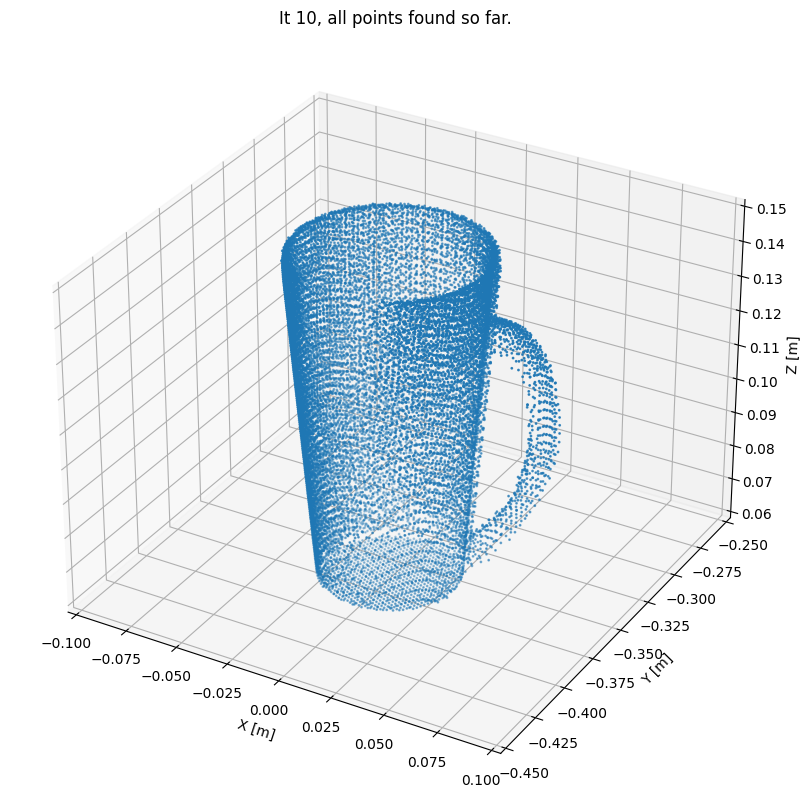

cam_pts_3d [[-0.082 -0.08  -0.078 ... -0.079 -0.076 -0.074]
 [-0.41  -0.41  -0.41  ... -0.295 -0.295 -0.295]
 [ 2.334  2.334  2.334 ...  2.361  2.361  2.362]]
tmp_world_pts [[-0.007 -0.009 -0.011 ...  0.006  0.004  0.002]
 [-0.406 -0.406 -0.405 ... -0.332 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.062  0.062  0.061]]
new_pts [[-0.019 -0.021 -0.023 ...  0.006  0.004  0.002]
 [-0.401 -0.4   -0.399 ... -0.332 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.062  0.062  0.061]]
[[-0.019 -0.021 -0.023 ...  0.006  0.004  0.002]
 [-0.401 -0.4   -0.399 ... -0.332 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.062  0.062  0.061]]
cam_pts_3d [[ 0.078  0.08   0.082 ...  0.088  0.09   0.092]
 [-0.418 -0.418 -0.418 ... -0.308 -0.308 -0.308]
 [ 2.287  2.287  2.287 ...  2.327  2.328  2.328]]
tmp_world_pts [[ 0.018  0.016  0.014 ... -0.009 -0.011 -0.013]
 [-0.403 -0.403 -0.404 ... -0.333 -0.334 -0.335]
 [ 0.152  0.152  0.152 ...  0.062  0.062  0.061]]
new_pts [[ 0.025  0.024  0.022 ... -0.009 -0.011 -0.01

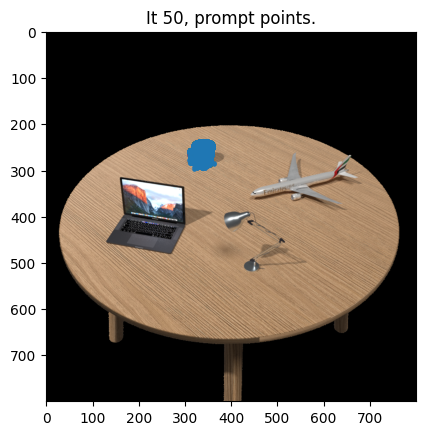

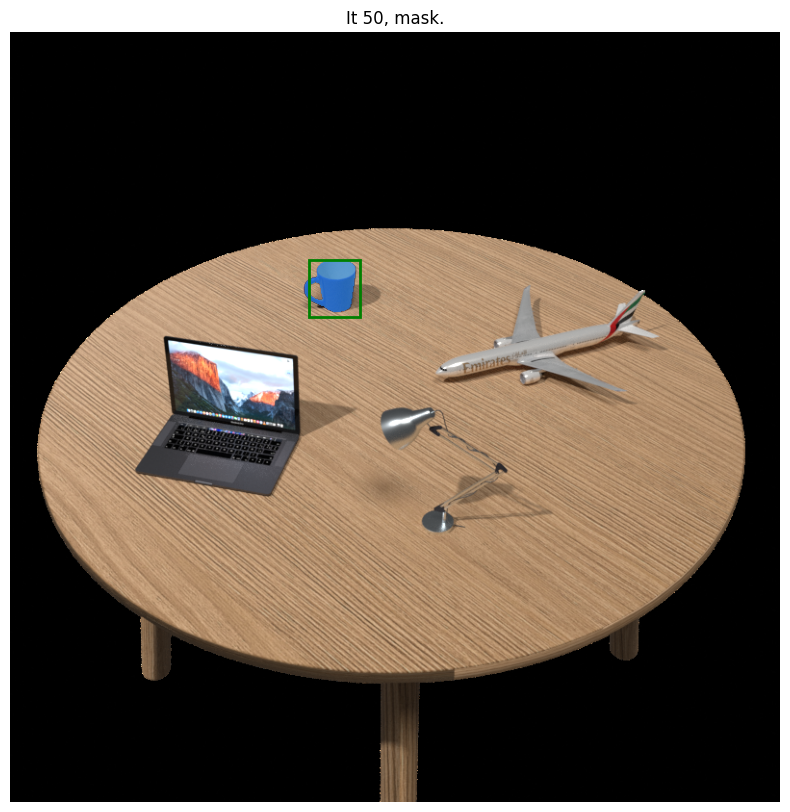

cam_pts_3d [[-0.133 -0.131 -0.15  ... -0.128 -0.126 -0.124]
 [-0.357 -0.357 -0.355 ... -0.239 -0.239 -0.24 ]
 [ 2.421  2.421  2.417 ...  2.419  2.419  2.42 ]]
tmp_world_pts [[-0.014 -0.016  0.004 ...  0.009  0.007  0.005]
 [-0.404 -0.403 -0.406 ... -0.333 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.061]]
new_pts [[-0.014 -0.016  0.004 ...  0.009  0.007  0.005]
 [-0.404 -0.403 -0.406 ... -0.333 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.061]]
[[-0.014 -0.016  0.004 ...  0.009  0.007  0.005]
 [-0.404 -0.403 -0.406 ... -0.333 -0.332 -0.332]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.061]]


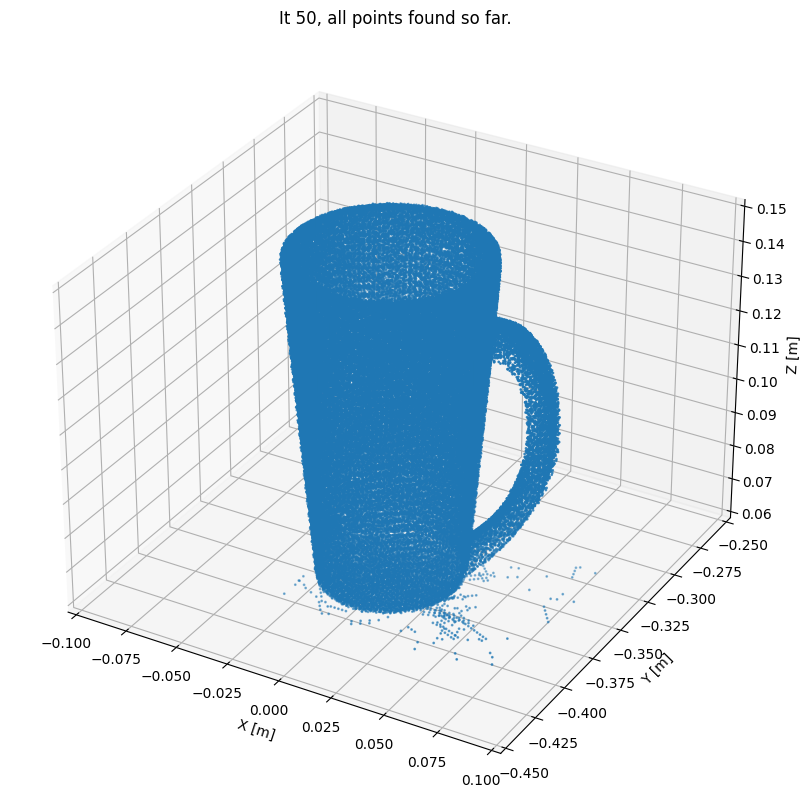

cam_pts_3d [[ 0.162  0.165  0.167 ...  0.207  0.209  0.211]
 [-0.237 -0.237 -0.237 ... -0.133 -0.133 -0.134]
 [ 2.503  2.505  2.506 ...  2.47   2.472  2.473]]
tmp_world_pts [[ 0.042  0.041  0.04  ... -0.027 -0.028 -0.029]
 [-0.373 -0.375 -0.378 ... -0.346 -0.349 -0.352]
 [ 0.153  0.152  0.152 ...  0.062  0.061  0.061]]
new_pts [[ 0.042  0.041  0.04  ... -0.027 -0.028 -0.029]
 [-0.373 -0.375 -0.378 ... -0.346 -0.349 -0.352]
 [ 0.153  0.152  0.152 ...  0.062  0.061  0.061]]
[[ 0.042  0.041  0.04  ... -0.027 -0.028 -0.029]
 [-0.373 -0.375 -0.378 ... -0.346 -0.349 -0.352]
 [ 0.153  0.152  0.152 ...  0.062  0.061  0.061]]
cam_pts_3d [[ 0.283  0.285  0.287 ...  0.304  0.306  0.308]
 [-0.068 -0.068 -0.068 ...  0.044  0.044  0.044]
 [ 2.002  2.002  2.003 ...  1.975  1.976  1.977]]
tmp_world_pts [[ 0.025  0.026  0.028 ... -0.021 -0.02  -0.018]
 [-0.327 -0.329 -0.33  ... -0.386 -0.387 -0.388]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.06 ]]
new_pts [[ 0.025  0.026  0.028 ... -0.021 -0.02  -0.01

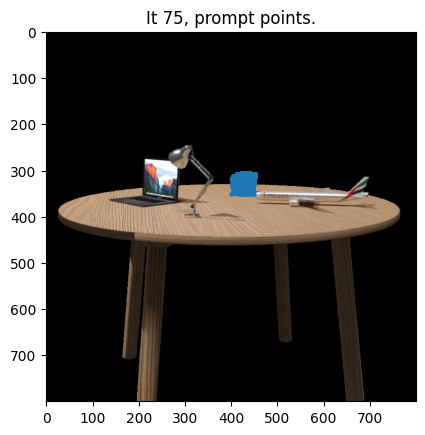

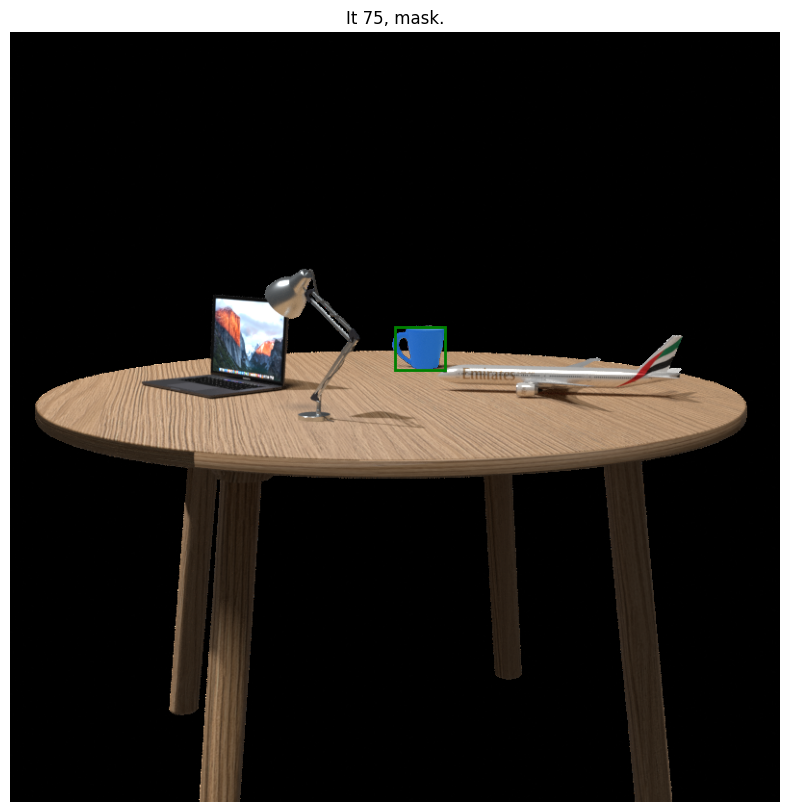

cam_pts_3d [[ 0.027  0.03   0.112 ...  0.084  0.087  0.089]
 [-0.21  -0.211 -0.211 ... -0.116 -0.116 -0.116]
 [ 2.54   2.547  2.548 ...  2.528  2.529  2.531]]
tmp_world_pts [[ 0.044  0.043 -0.038 ... -0.017 -0.019 -0.021]
 [-0.352 -0.36  -0.377 ... -0.336 -0.338 -0.34 ]
 [ 0.152  0.152  0.151 ...  0.061  0.061  0.061]]
new_pts [[ 0.044  0.043 -0.038 ... -0.017 -0.019 -0.021]
 [-0.352 -0.36  -0.377 ... -0.336 -0.338 -0.34 ]
 [ 0.152  0.152  0.151 ...  0.061  0.061  0.061]]
[[ 0.044  0.043 -0.038 ... -0.017 -0.019 -0.021]
 [-0.352 -0.36  -0.377 ... -0.336 -0.338 -0.34 ]
 [ 0.152  0.152  0.151 ...  0.061  0.061  0.061]]


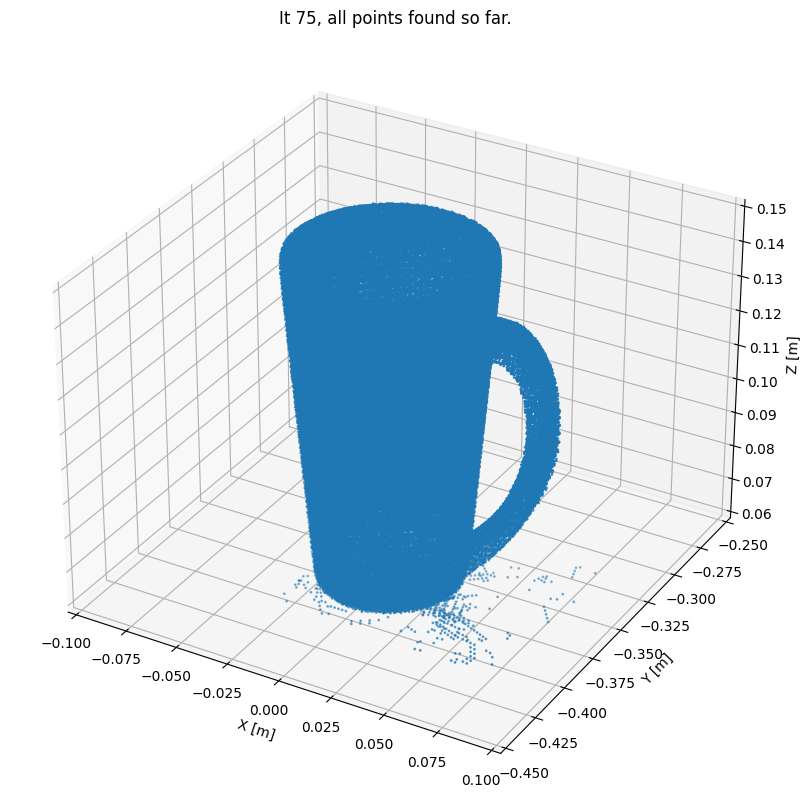

cam_pts_3d [[ 0.015  0.017  0.018 ...  0.031  0.033  0.035]
 [-0.015 -0.015 -0.015 ...  0.097  0.097  0.097]
 [ 1.863  1.864  1.864 ...  1.832  1.833  1.834]]
tmp_world_pts [[-0.006 -0.004 -0.003 ...  0.005  0.007  0.009]
 [-0.32  -0.32  -0.32  ... -0.394 -0.393 -0.393]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.06 ]]
new_pts [[-0.006 -0.004 -0.003 ...  0.005  0.007  0.009]
 [-0.32  -0.32  -0.32  ... -0.394 -0.393 -0.393]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.06 ]]
[[-0.006 -0.004 -0.003 ...  0.005  0.007  0.009]
 [-0.32  -0.32  -0.32  ... -0.394 -0.393 -0.393]
 [ 0.152  0.152  0.152 ...  0.061  0.061  0.06 ]]
cam_pts_3d [[-0.367 -0.348 -0.346 ... -0.361 -0.366 -0.364]
 [-0.215 -0.205 -0.205 ... -0.082 -0.079 -0.079]
 [ 2.254  2.147  2.147 ...  2.157  2.14   2.143]]
tmp_world_pts [[-0.089 -0.042 -0.042 ...  0.064  0.075  0.073]
 [-0.414 -0.378 -0.376 ... -0.358 -0.36  -0.359]
 [ 0.059  0.152  0.152 ...  0.09   0.104  0.101]]
new_pts [[-0.042 -0.042 -0.036 ...  0.064  0.075  0.07

In [26]:

import os
import copy
from sklearn.cluster import KMeans
all_world_pts = copy.deepcopy(world_pts)

it = 1

# show_its = [1,4,10]
show_its = [1,4,10,50,75,99]

end_idx = -1 # set this to a different number, e.g. 10, for faster debugging

#TODO: add all plots generated to gradescope submission
for transform, file_path, depth in zip(dataset.transforms[1:end_idx], dataset.file_paths[1:end_idx], depths[1:end_idx]):
    # compute 3d points
    image = cv2.imread(os.path.join('images/dataset/', file_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    prompt_points = filter_for_box(all_world_pts,transform) # (3) Carefully choose the bounding box dimensions to avoid noise to have a big effect on the result.

    if it in show_its:
        plt.imshow(image)
        # scatter plot the img_pts
        plt.scatter(prompt_points[0,:],prompt_points[1,:],s=5)
        plt.title('It {}, prompt points.'.format(it))
        plt.show()

    predictor.set_image(image)

    prompt_box = prompt_points_to_box(prompt_points) # (3) Choose the bounding box points based on the filtered points.

    masks, scores, _ = predictor.predict(
        box=prompt_box,
        point_labels=[1],
        multimask_output=False,
    )

    if it in show_its:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks, plt.gca())
        show_box(prompt_box, plt.gca())
        plt.axis('off')
        plt.title('It {}, mask.'.format(it))
        plt.show()

    mask = masks.reshape((h, w, 1))
    cam_pnts_3d = mask2cam(mask,dataset.K,depth, 2.55)
    tmp_world_pts = cam2world(cam_pnts_3d,transform)

    if keep_score(scores): # (1) Filter out masks that have a score that's too low.
        tmp_world_pts = keep_dist(tmp_world_pts,all_world_pts) # (2) Filter out points that are too far away from anything else we've seen so far.
        all_world_pts = np.hstack([all_world_pts,tmp_world_pts])
        print(tmp_world_pts)

    if it in show_its:
        viz_pts_3d(all_world_pts,title='It {}, all points found so far.'.format(it),xrange=[-0.1,0.1],yrange=[-0.45,-0.25],zrange=[0.06,0.15])

    it+=1







## Visualize all 3D points

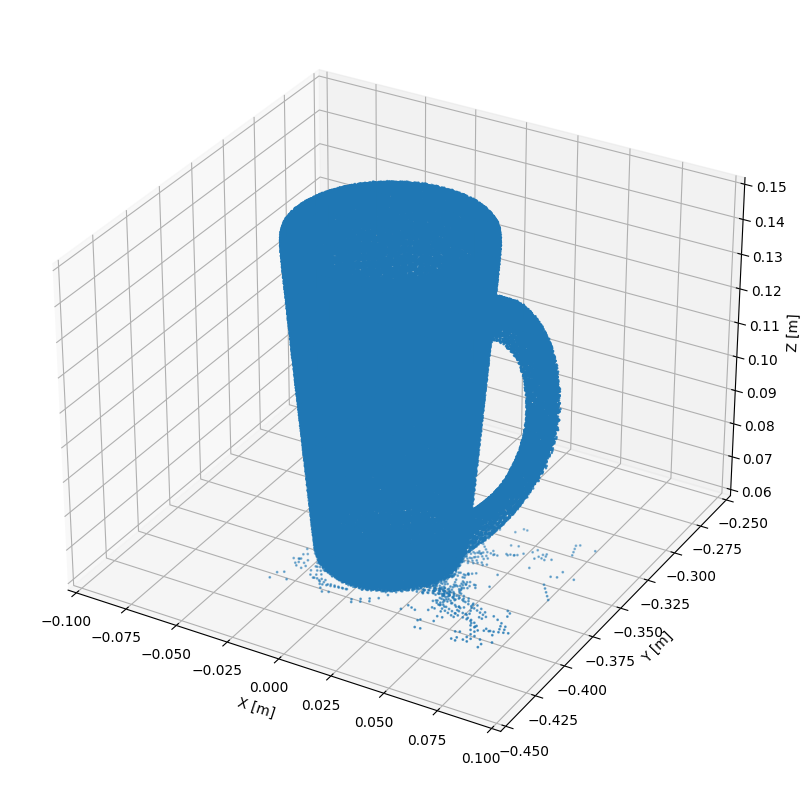

In [27]:
#TODO: do NOT need to add to gradescope submission
viz_pts_3d(all_world_pts,xrange=[-0.1,0.1],yrange=[-0.45,-0.25],zrange=[0.06,0.15])

## Q5: Statistical outlier removal [3 pts]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


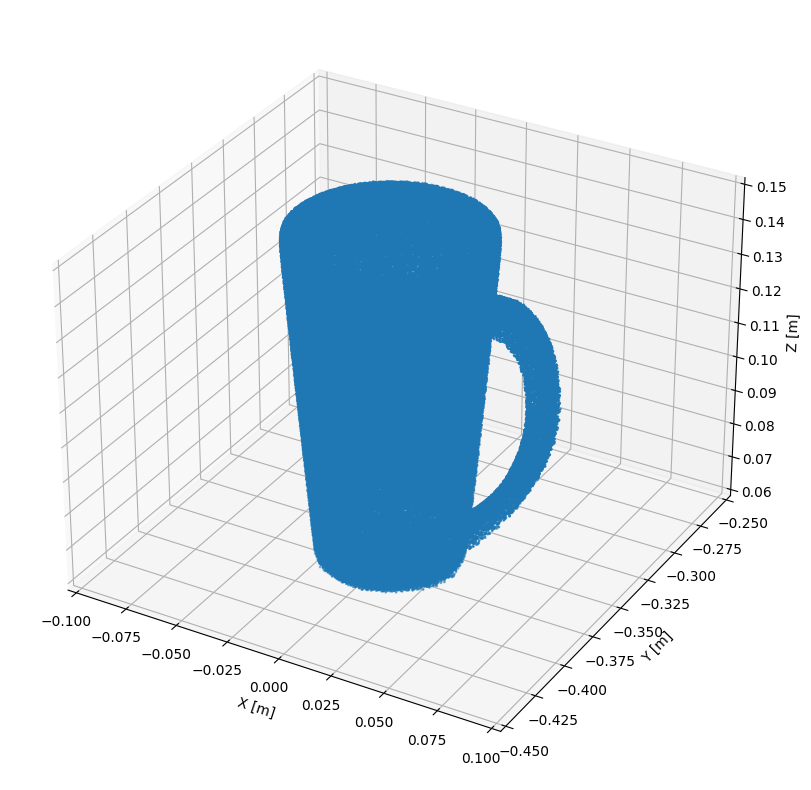

In [28]:
def filter_points(points,nb_neighbors=20,std_ratio=2.0):
    import open3d as o3d
    # filter points using open3d statistical outlier removal. [3 pts]
    # TODO: YOUR CODE HERE
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points.T)
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    points_f = points[:, ind]
    return points_f

all_world_pts_filtered = filter_points(all_world_pts[:3,:])

#TODO: add this plot to gradescope submission
viz_pts_3d(all_world_pts_filtered,xrange=[-0.1,0.1],yrange=[-0.45,-0.25],zrange=[0.06,0.15])

### Expected Output

Below is the output we achieved at the end of the homework, you implementation should be similar to receive full credit.

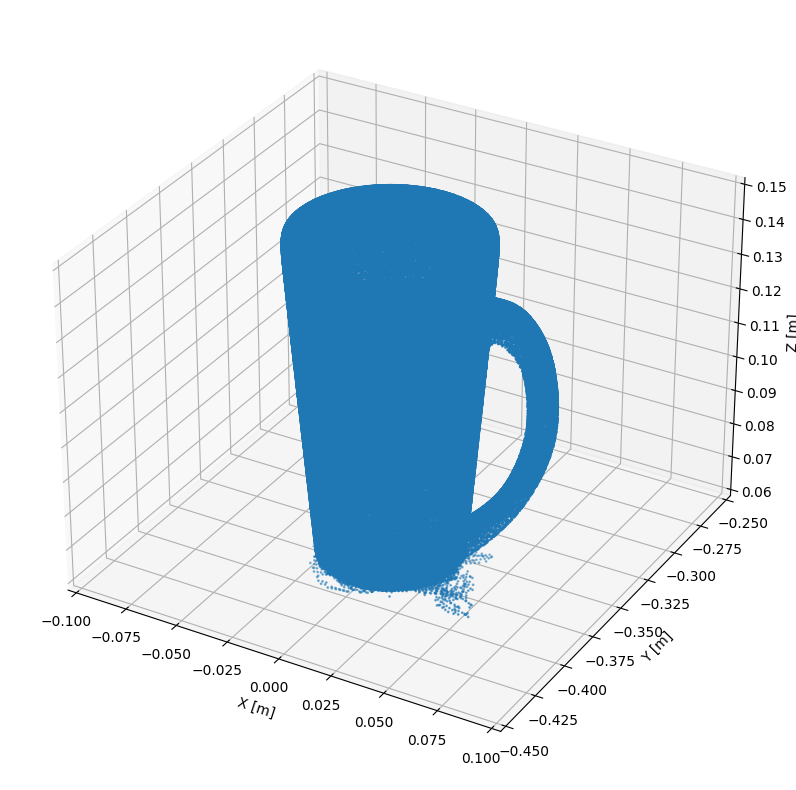

In [29]:
Image(filename="images/expected_output.png", width=img_size, height=img_size)

## Q6 Extra credit: 3D Segmentation without Ground Truth Depth [10 pts Max]

So far we have provided you with ground truth depth from the 3D rendering toolbox. For a maximum of 10 extra points, can you achieve similar accuracy without using ground truth depth? You can use any toolbox/repository you like, as long as they infer dense depth maps: depth for every pixel in the image. Here is one approach we believe would be relatively straightforward:
* The dataset is formatted for Neural Radiance Fields (NeRFs). You should be able to run NeRF on this dataset with little modifications. 
* Suggested NeRF pipeline: [Torch-NGP](https://github.com/ashawkey/torch-ngp). It runs fast using a cuda backend, but all the high-level features are implemented in Torch.
* Some necessary changes: (1) Modify the code to only use the training data, no testing or validation (not provided in dataset). You could also copy training data to a test and validation folder and create the necessary json files. (2) Modify the code to return all *train* depth maps in a `.npy` array, in units [meters].

Any other methods are allowed and encouraged, as long as they infer dense depth maps: depth for every pixel in the image. Keep in mind the difference between z-depth as in Blender (the distance along the cameras principle axis), depth as euclidean distance from the camera center. 